# Lab 5 - Variational Autoencoder for Deep Generative Learning

## Objective

* To build a variational autoencoder that can generate images from the learned model 

**Suggested reading**: 
* [Variational Bayesian methods on Wiki](https://en.wikipedia.org/wiki/Variational_Bayesian_methods)
* [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)
* [Variational autoencoders notes](https://deepgenerativemodels.github.io/notes/vae/)

This notebook is based on the [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) by Jaan Altosaar, PyTorch's [Variational Autoencoder code](https://github.com/pytorch/examples/blob/master/vae/main.py), Paul Guerrero's [Variational Autoencoders](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb) notebook, [Pyro](http://pyro.ai/)'s [Variational Autoencoders tutorial](http://pyro.ai/examples/vae.html), and [Nitarshan](https://github.com/nitarshan)'s [Variational Autoencoders](https://github.com/nitarshan/variational-autoencoder/blob/master/Variational%20Autoencoder%20Tutorial.ipynb) notebook.


## Why

**Deep generative models** aim to combine the interpretable representations and quantified uncertainty offered by probabilistic models, with the flexibility and scalable learning of deep neural networks, from the [Deep Generative Models](http://stat.columbia.edu/~cunningham/teaching/GR8201/) course by [John P. Cunningham](http://stat.columbia.edu/~cunningham/). 

**Variational autoencoders** are such deep generative models. They let us design complex generative models of data, and fit them to large datasets. They yield state-of-the-art machine learning results in image generation and reinforcement learning and can generate [images of fictional celebrity faces](https://www.youtube.com/watch?v=XNZIN7Jh3Sg) and [high-resolution digital artwork](https://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/).

# Variational Autoencoder (VAE)
Like all autoencoders, the variational autoencoder is primarily used for unsupervised learning of hidden/latent representations. However, they are fundamentally different in that they approach the problem from a probabilistic perspective. They specify a joint distribution over the observed and latent variables, and approximate the intractable posterior conditional density over latent variables with [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods).

### Neural network architecture
A variational autoencoder consists of an encoder, a decoder, and a loss function as a typical autoencoder: 

<img src="https://jaan.io/images/encoder-decoder.png"
     alt="Markdown Monster icon"
     style="height: 200px" />
     
* The **encoder** takes a datapoint $x$ as the input and encodes it to produce a hidden/latent representation $z$ as the output, with parameters $\theta$ (weights and biases). The encoder in a VAE can be written as a Gaussian probability density $q_\theta (z \mid x)$ to model a stochastic lower-dimensional space is stochastic. The encoder outputs parameters to $q_\theta (z \mid x)$ and we can sample from this distribution to get noisy values of the representations $z$. 
* The **decoder** $p_\phi(x\mid z)$ takes the representation $z$ as the input and outputs the parameters to the probability distribution of the data $p_\phi (x\mid z)$, with parameters $\phi$ (weights and biases). The reconstruction log-likelihood $\log p_\phi (x\mid z)$ tells us how effectively the decoder has learned to reconstruct (autoencode) an input image $x$ given its latent representation $z$.

* <p>The **loss function** is the negative log-likelihood with a regularizer. The loss function $l_i$ for a single datapoint $x_i$ is:
\begin{equation}
\:\\
l_i(\theta, \phi) = - \mathbb{E}_{z\sim q_\theta(z\mid x_i)}[\log p_\phi(x_i\mid z)] + \mathbb{KL}(q_\theta(z\mid x_i) \mid\mid p(z))\\
\tag{1}\end{equation}
Datapoints are assumed to be independent so the total loss is $\sum_{i=1}^N l_i$ for $N$ total datapoints. The first term aims for reconstruction and is defined as the expected negative log-likelihood of the $i$-th datapoint, with the expectation taken w.r.t. to the encoder’s distribution over the representations. The second term is a regularizer in the form of the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the encoder’s
distribution $q_\theta(z\mid x)$ (the approximation) and $p(z)$ (the ground truth), measuring their mismatch.
 
The variational autoencoder specifies $p$ as a standard Gaussian distribution with mean zero and variance one. If the encoder outputs representations $z$ having a distribution different from a standard Gaussian, there will be a penalty (proportional to the amount of difference) in the loss. The training of VAE uses gradient descent to optimize the loss with respect to the parameters of the encoder and decoder $\theta$ and $\phi$. 

**Example**: A $28\times 28$ handwritten digit image can be represented as $0$ or $1$ (black or white). We use a Bernoulli distribution to represent the probability distribution of a single pixel. The decoder receives the latent representation of a digit $z$ and outputs $784$ Bernoulli parameters, one for each of the $784$ pixels, from which we can **sample** or **generate** digits.

### Probabilistic modelling in variational autoencoder 

*This section is **optional**. You may skip it safely if you are only interested in using VAE.*

From a probability model perspective, a variational autoencoder is a latent variable model that **generates** a datapoint $x$ from latent variables $z$ with a joint probability $p(x, z) = p(x \mid z) p(z)$. 
<img src="https://jaan.io/images/graphical-model-variational-autoencoder.png"
     alt="Markdown Monster icon"
     style="height: 200px" />
For each datapoint $i$, latent variable $z_i$ are first drawn from a prior distribution $p(z)$: $z_i \sim p(z)$. Then, a datapoint $x_i$ is drawn from the likelihood $p(x\mid z)$: $x_i \sim p(x\mid z)$. Recall that we have $p(x,z) = p(x\mid z)p(z)$. For a black and white digit image, the likelihood has a Bernoulli distribution.

With a Bayesian approach, the **inference** task is to learn good values of the latent variables given observed data in terms of the posterior

$$p(z \mid x) = \frac{p(x \mid z)p(z)}{p(x)}.$$

The denominator $p(x)$ is the marginal distribution of $x$ (the evidence): $p(x) = \int p(x \mid z) p(z) dz$. This integral requires exponential time to compute so we need to an approximation.  

**Variational inference** approximates the posterior with a family of distributions $q_\lambda(z \mid x)$ indexed by the variational parameter(s) $\lambda$, which are the mean and variance for Gaussian distributions: $\lambda = (\mu, \sigma^2))$. We can use the **Kullback-Leibler divergence** to measure how well the variational posterior $q(z \mid x)$ approximates the true posterior $p(z \mid x)$: 

$$\mathbb{KL}(q_\lambda(z \mid x) \mid \mid p(z \mid x)) = \mathbf{E}_q[\log q_\lambda(z \mid x)]- \mathbf{E}_q[\log p(x, z)] + \log p(x)$$

Optimizing the KL divergence above is intractable. However, if we define the **Evidence Lower BOund** (ELBO)

$$ELBO(\lambda) = \mathbf{E}_q[\log p(x, z)] - \mathbf{E}_q[\log q_\lambda(z \mid x)],$$

then we can combine this with the KL divergence and rewrite the evidence (marginal distribution) as</p>

$$\log p(x) = ELBO(\lambda) + \mathbb{KL}(q_\lambda(z \mid x) \mid \mid p(z \mid x))$$

By Jensen’s inequality, the KL divergence is always non-negative so minimizing this KL divergence is equivalent to maximizing the ELBO because $p(x)$ is fixed (though intractable). 


---
### Question 1

Why is $ELBO(\lambda)$ the lower bound for $\log p(x)$?

**Answer**: 

---

The ELBO enables approximate posterior inference.Maximizing the ELBO is equivalent (but computationally tractable) to minimizing the KL divergence between the approximate and exact posteriors.

The variational autoencoder model further assumes that no datapoint shares its latent $z$ with another datapoint so that we can decompose the ELBO as a sum of the ELBOs for each single datapoint:

$$ELBO_i(\lambda) = \mathbb{E}_{q_\lambda(z\mid x_i)}[\log p(x_i\mid z)] - \mathbb{\mathbb{KL}}(q_\lambda(z\mid x_i) \mid\mid p(z)).$$

Now, we can use stochastic gradient descent with respect to the parameters $\lambda$ (which are shared across datapoints).

---
### Question 2

Verify that this definition for $ELBO_i(\lambda)$ is equivalent to our previous definition of the ELBO. 

*Hint: expand the log joint into the prior and likelihood terms and use the product rule for the logarithm.*

**Answer**: 

---

Next, we parametrize the approximate posterior $q_\theta (z \mid x, \lambda)$ with an **inference network** (encoder) that takes data $x$ in and outputs parameters $\lambda$, with learnable parameter $\theta$ (weights and biases). And we parameterize the likelihood $p(x \mid z)$ with a **generative network** (decoder) that takes latent variables in and outputs parameters to the data distribution $p_\phi(x \mid z)$, with learnable parameters $\phi$ (weights and biases). $\theta$ and $\phi$ can be learned by maximizing the ELBO using stochastic gradient descent with minibatch. We can write the ELBO and include the inference and generative network parameters as:</p>

$$ELBO_i(\theta, \phi) = \mathbb{E}_{q_\theta(z\mid x_i)}[\log p_\phi(x_i\mid z)] - \mathbb{KL}(q_\theta(z\mid x_i) \mid\mid p(z)).$$

Notice that this evidence lower bound is the negative of the loss function $l_i(\theta, \phi)$ defined in Equation (1): $ELBO_i(\theta, \phi) = -l_i(\theta, \phi)$. 

The probability model approach reveals that two terms in Equation (1) aim to minimize the KL divergence (mismatch) between the approximate posterior $q_\lambda(z \mid x)$ and (true) model posterior $p(z \mid x)$.

**Summary**: In this variational inference, we've defined a probability model $p$ of latent variables and data, as well as a variational family $q$ for the latent variables to approximate our posterior. Then the variational inference algorithm can learn the variational parameters through gradient *ascent* on the ELBO. 


### Reparametrization trick

To implement the variational autoencoder, we need to take derivatives w.r.t. the parameters of a stochastic variable. If $z$  is drawn from a distribution $q_\theta (z \mid x)$, how to take derivatives of a function of $z$ with respect to $\theta$? The  sample $z$ is fixed, but intuitively its derivative should be nonzero.

For Gaussian distributions, we can reparametrize samples in a clever way so that the stochasticity is independent of the parameters, e.g. by making samples to deterministically depend on the parameters of the distribution. For example, in a Gaussian variable with mean $\mu$ and standard devation $\sigma$, we can sample from it as:</p>

$$z = \mu + \sigma \odot \epsilon,$$

<p>where $\epsilon \sim \mathcal{N}(0, 1)$. In this way, we have defined a function which depends on the parameters deterministically so that we can take derivatives of functions involving $z$, $f(z)$ w.r.t. to the parameters of its distribution $\mu$ and $\sigma$, which are output by an inference network with parameters $\theta$ that we optimize. 

<img src="https://jaan.io/images/reparametrization.png"
     alt="Markdown Monster icon"
     style="height: 200px" />

Through this trick, we can backpropagate w.r.t. $\theta$ through the objective (the ELBO) which is a function of samples of the latent variables $z$. 

### Variational Autoencoder via PyTorch

Let us implement a VAE in PyTorch to learn a generative model for handwritten digit images from the  MNIST dataset. We use the following common setup: a multivariate Gaussian distribution for the conditional distribution $q_{\theta}(z | x)$  and a multivariate Bernoulli distribution for the conditional distribution $p_{\phi}(x | z)$, which reduces the reconstruction loss (the first term in Equation (1)) to the pixel-wise binary cross-entropy loss. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf) for details.

#### Set up and get ready to build a VAE
First, get ready by importing libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from tqdm.notebook import tnrange

import torch
from torch.utils.data.dataloader import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid 

torch.manual_seed(2020)
sns.set_style('dark')
%matplotlib inline

Set up the experiments, including data loaders. MNIST images are gray-level images with pixel values in [0,1], which will be treated as probabilities of being white (0 probability means black).

In [2]:
batch_size=128   # input batch size for training (default: 128)
num_epochs=10    # number of epochs to train (default: 10)')
num_visual=16    # For compare original and constructed digits
num_grid=20      # For visualising generated digits in grid
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if you have one
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = DataLoader(datasets.MNIST('data', train=True, download=True, 
        transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(datasets.MNIST('data', train=False, 
        transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True, **kwargs)

C:\Users\eehpl\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


#### Construct the VAE

Now construct the VAE model and do an inspection. We use fully connected layers here. 

In [3]:
class VAE(nn.Module):
    def __init__(self,latent_dim=20,hidden_dim=500):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim) #logvar
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

myVAE = VAE().to(device)
print(myVAE)

VAE(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc21): Linear(in_features=500, out_features=20, bias=True)
  (fc22): Linear(in_features=500, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=784, bias=True)
)


Define the loss function and choose the optimizer. 

In [4]:
optimizer = optim.Adam(myVAE.parameters(), lr=learning_rate)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (BCE + KLD) / recon_x.size(0) # normalize by batch size



#### Training, testing and visualisation

Let us train the model and plot the losses against batches.

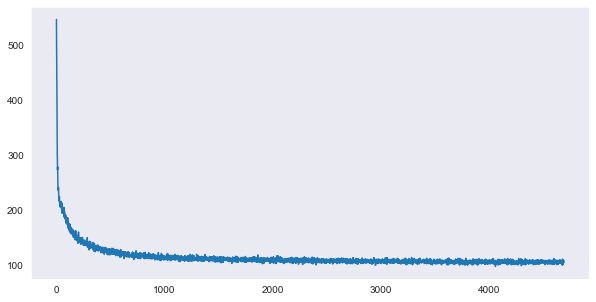

In [5]:
# Training
def train(model,optimizer,dataloader):
    model.train() # set to training mode
    losses = []
    for epoch in tnrange(num_epochs,desc='Epochs'):
        for data, _ in dataloader:        
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            losses.append(loss.item()) # train_loss += loss.item()
            optimizer.step()
    return losses

train_losses = train(myVAE,optimizer,train_loader)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

Zoom in to the converging region and compute the moving average of losses to observe the trend.

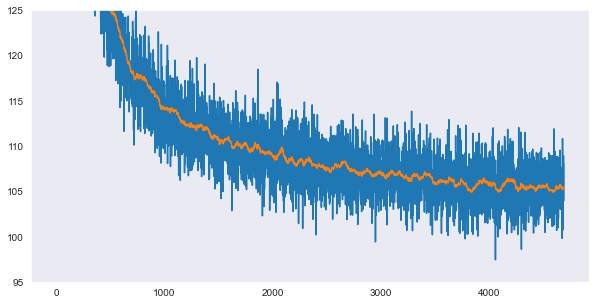

In [6]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid',ylim=(95,125)):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(train_losses)

Evaluate on the test dataset.

In [7]:
# Testing
def test(model,dataloader):
    model.eval() # set to evaluation mode
    test_loss = 0
    for data, _ in dataloader:
        with torch.no_grad():
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            loss = loss_function(recon_batch, data, mu, logvar).item()
            test_loss += loss*data.size(0)
    return test_loss/len(dataloader.dataset)

test_loss = test(myVAE, test_loader)
print(test_loss)    

105.42360033798218


Let us compare the images reconstructed from the learned latent representations with the original images. 

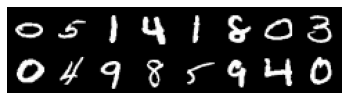

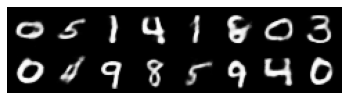

In [8]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=num_visual):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
    
    with torch.no_grad(): 
        data,_ = iter(dataloader).next()
        data = data.to(device)
        data = data[0:num,:,:]        
        recon_batch,_,_ = model(data)
        recon_batch = recon_batch.data.view(num, 1, 28, 28)
        imshow(make_grid(data))
        imshow(make_grid(recon_batch))

visualize_mnist_vae(myVAE,test_loader)

#### 2D latent space studies
Let us set the latent dimension to 2 for easy visualisation. With this setting, the reconstruction is poorer than higher latent dimension.


154.82062296447754


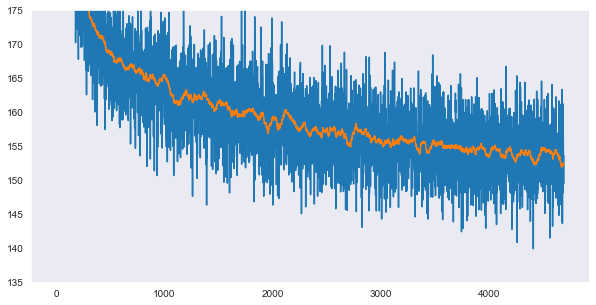

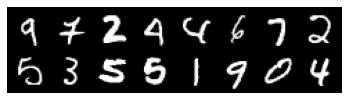

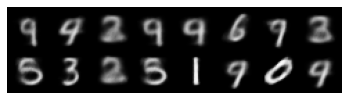

In [9]:
# Train, test and visualize reconstruction using a 2D latent space
myVAE2 = VAE(latent_dim=2)
optimizer2 = optim.Adam(myVAE2.parameters(), lr=learning_rate)

train2_losses = train(myVAE2,optimizer2,train_loader)
test2_loss = test(myVAE2,test_loader)

print(test2_loss)
visualize_losses_moving_average(train2_losses,ylim=(135,175))
visualize_mnist_vae(myVAE2,test_loader)

Let us visualise the latent representations in a 2D space with the ground truth class labels to observe the *clustering* effects: the latent representations for the different classes of digits are placed in different parts of the latent space in most cases, though with overlap.

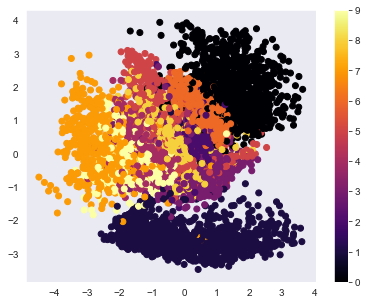

In [10]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    with torch.no_grad():
        for images,labels in iter(dataloader):
            z_means,_ = model.encode(images.view(-1,784)) # We visualise the mean
            z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
            z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
            all_labels = np.append(all_labels,labels.numpy())

    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(myVAE2,test_loader)

#### VAE as a digit image generator

Using the learned generative VAE model, we can sample/generate new digit images via sampling their latent vectors at a regular grid from its prior distribution. We display them along the 2D latent space manifold. We can observe interesting patterns on the regularly spaced grid and interpret what each dimension of the latent space has captured. Although the generated digits are not perfect and have artefacts, they are usually better than for a non-variational Autoencoder.

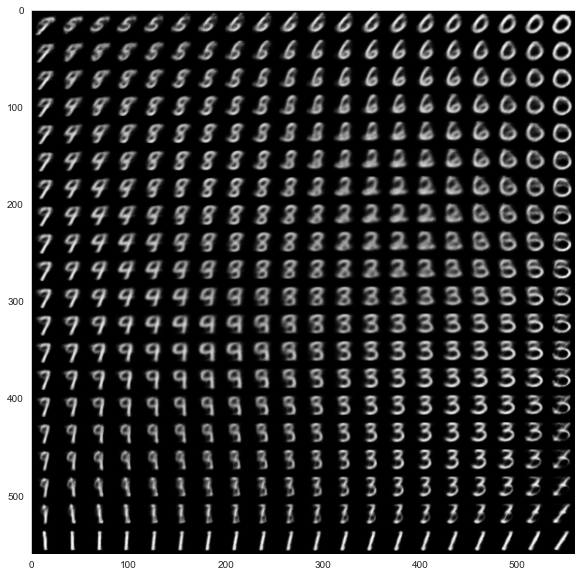

In [11]:
# Visualize digits generated from latent space grid
def visualize_decoder(model,num=num_grid,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type
    with torch.no_grad():
        for i, x in enumerate(range_space):
            for j, y in enumerate(reversed(range_space)):
                z = torch.FloatTensor([[x,y]])
                image = model.decode(z).view(-1,1,28,28)
                image = image.data.numpy()
                image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid, cmap='gray')
    plt.show()

visualize_decoder(myVAE2)

---
### Question 3

* Make a *video* in any video or `gif` format to display the digits generated from the 2D latent space as frames and/or the progressive learning of the model (i.e. batch as the time axis).

**Answer**: 

---

## 3. Exercises


* Implement a convolutional VAE. An example is available [here](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb).
* Explore other VAEs following the [PyTorch-VAE](https://github.com/AntixK/PyTorch-VAE) repository to generate new faces from celebrities.
* Study [A Tutorial on Variational Autoencoders with a Concise Keras Implementation](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/) by Louis Tiao and implement the same in pytorch.
* Explore [PyroLab 1 - Bayesian Linear Regression for Generative Learning with Pyro](https://github.com/haipinglu/SimplyDeep/blob/master/PyroLab%201%20-%20Bayesian%20Linear%20Regression%20for%20Generative%20Learning%20with%20Pyro.ipynb)
* Explore [PyroLab 2 - Variational Autoencoder for Deep Generative Learning](https://github.com/haipinglu/SimplyDeep/blob/master/PyroLab%202%20-%20Variational%20Autoencoder%20for%20Deep%20Generative%20Learning.ipynb)
